# Classify Flowers (Image Classification) with ViT using multi-GPU

This tutorial contains complete code to fine-tune ViT to perform image classification on (Flowers) dataset. 
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the Flowers dataset from http://download.tensorflow.org/example_images/flower_photos.tgz
- Extract it to a folder
- Load ViT Model using tf-transformers
- Build train and validation dataset (on the fly) feature preparation using
feature extractor from tf-transformers.
- Build your own model by combining ViT with a classifier
- Train your own model, fine-tuning ViT as part of that
- Save your model and use it to classify images
- Use the end-to-end (preprocessing + inference) in production setup

If you're new to working with the MNLI dataset, please see [Flowers Dataset](http://download.tensorflow.org/example_images/flower_photos.tgz) for more details.

In [ ]:
!pip install tf-transformers

!pip install transformers

!pip install wandb

In [13]:
import tensorflow as tf
import random
import collections
import wandb
import io
import tqdm

import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn.metrics as sk_metrics
import numpy as np

print("Tensorflow version", tf.__version__)
print("Devices", tf.config.list_physical_devices())

from tf_transformers.models import ViTModel, Classification_Model, ViTFeatureExtractorTF
from tf_transformers.core import Trainer
from tf_transformers.optimization import create_optimizer
from tf_transformers.losses.loss_wrapper import get_1d_classification_loss

Tensorflow version 2.7.0
Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
FLOWERS_DIR = '/home/jovyan/DATASETS/flower_photos/'
RANDOM_SEED = 1234
TRAIN_FRACTION = 0.8

### Prepare Data

1. Download Flowers dataset from the above link
2. Extract it to a folder by `tar -xvf flower_photos.tgz`

In [4]:
def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random(RANDOM_SEED)
    is_root = True
    for (dirname, subdirs, filenames) in tf.io.gfile.walk(FLOWERS_DIR):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            is_root = False
        # The sub directories give us the image files for training.
        else:
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            label = dirname.split('/')[-1]
            label_class = label_to_class[label]
            # An example is the image file and it's label class.
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            num_train = int(len(filenames) * TRAIN_FRACTION)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])

    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    return train_examples, test_examples, classes

TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('There are %d test images' % len(TEST_EXAMPLES))


The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
There are 736 test images


### Plot few examples

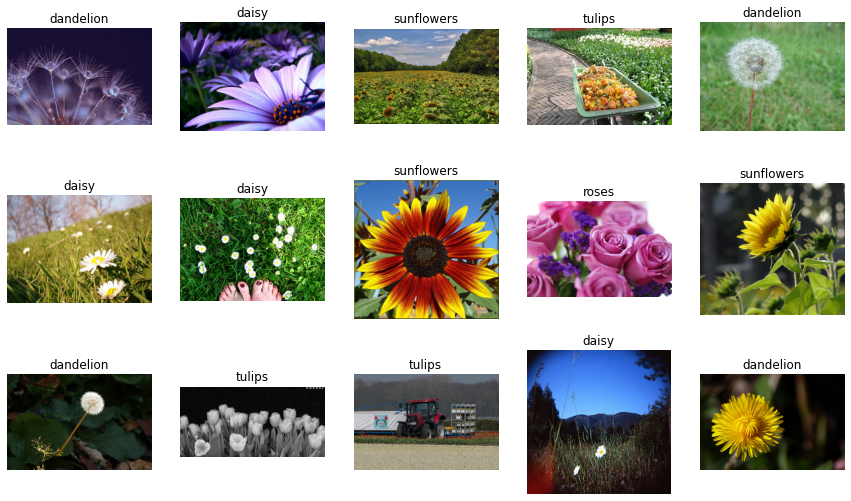

In [7]:
def get_label(example):
    """Get the label (number) for given example."""
    return example[1]

def get_class(example):
    """Get the class (string) of given example."""
    return CLASSES[get_label(example)]

def get_encoded_image(example):
    """Get the image data (encoded jpg) of given example."""
    image_path = example[0]
    return tf.io.gfile.GFile(image_path, 'rb').read()

def get_image(example):
    """Get image as np.array of pixels for given example."""
    return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, flower_class) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_class)

NUM_IMAGES = 15
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

### Load Model, Optimizer , Trainer

Our Trainer expects ```model```, ```optimizer``` and ```loss``` to be a function.

* `key` attribute in `Classification_Model` denotes, which model output has to be consumed by the
`Classification_Model` for classification. Default is `cls_output`.

In [6]:
# Load Model
def get_model(model_name, num_classes, is_training, use_dropout):
    """Get Model"""
    def model_fn():
        model = ViTModel.from_pretrained(model_name)
        classification_model = Classification_Model(model, num_classes=NUM_CLASSES, key='cls_output')
        classification_model = classification_model.get_model()
        return classification_model
    return model_fn

# Load Optimizer
def get_optimizer(learning_rate, examples, batch_size, epochs, use_constant_lr=False):
    """Get optimizer"""
    steps_per_epoch = int(examples / batch_size)
    num_train_steps = steps_per_epoch * epochs
    warmup_steps = int(0.1 * num_train_steps)

    def optimizer_fn():
        optimizer, learning_rate_fn = create_optimizer(learning_rate, num_train_steps, warmup_steps, use_constant_lr=use_constant_lr)
        return optimizer

    return optimizer_fn

# Load trainer
def get_trainer(distribution_strategy, num_gpus=0, tpu_address=None):
    """Get Trainer"""
    trainer = Trainer(distribution_strategy, num_gpus=num_gpus, tpu_address=tpu_address)
    return trainer

### Prepare Data for Training

We will make use of ```Tensorflow io operations``` to do ```on-the-fly``` preprocessing, without having any
overhead of pre prepapre the data in the form of ```pickle```, ```numpy``` or ```tfrecords```.

In [7]:
# Load dataset
def load_dataset(dataset, feature_extractor, batch_size, drop_remainder):
    """
    Args:
      dataset; tf dataset
      batch_size: int (batch_size)
      drop_remainder: bool (to drop remaining batch_size, when its uneven)
    """
    def parse(item):
        result = {}
        input_pixels = feature_extractor({'image': tf.expand_dims(item['image_path'], axis=0)})['input_pixels'] 
        result['input_pixels'] = tf.squeeze(input_pixels, axis=0) # squeeze to remove batching early on
        result['labels'] = item['label']
        return result
    
    def expand_labels(item):
        result = {}
        result['input_pixels'] = item['input_pixels']
        
        labels = {}
        labels['labels'] = tf.expand_dims(item['labels'], axis=1)
        return result, labels


    tfdataset = dataset.map(parse, num_parallel_calls =tf.data.AUTOTUNE)
    tfdataset = tfdataset.batch(batch_size, drop_remainder=drop_remainder).map(expand_labels,
                                                                               num_parallel_calls=tf.data.AUTOTUNE)

    # Shard
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO
    tfdataset = tfdataset.with_options(options)
    
    return tfdataset


TRAIN_EXAMPLES_dict = {'image_path': [], 'label': []}
for (image_path, label) in TRAIN_EXAMPLES:
    TRAIN_EXAMPLES_dict['image_path'].append(image_path)
    TRAIN_EXAMPLES_dict['label'].append(label)
    
VALIDATION_EXAMPLES_dict = {'image_path': [], 'label': []}
for (image_path, label) in TEST_EXAMPLES:
    VALIDATION_EXAMPLES_dict['image_path'].append(image_path)
    VALIDATION_EXAMPLES_dict['label'].append(label)
    
# a dict is easy for tf.Dataset
train_ds = tf.data.Dataset.from_tensor_slices(TRAIN_EXAMPLES_dict)

# a dict is easy for tf.Dataset
valid_ds = tf.data.Dataset.from_tensor_slices(VALIDATION_EXAMPLES_dict)

2022-03-15 05:50:26.562746: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 05:50:27.888017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30945 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:85:00.0, compute capability: 7.0
2022-03-15 05:50:27.890730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30945 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


### Prepare Dataset

1. Set necessay hyperparameters.
2. Prepare ```train dataset```, ```validation dataset```.
3. Load ```model```, ```optimizer```, ```loss``` and ```trainer```.

In [8]:
# Data configs
model_name = 'vit-base-patch16-224'
batch_size = 64

# Model configs
learning_rate = 1e-5
epochs = 3
num_classes = NUM_CLASSES
model_checkpoint_dir = 'MODELS/vit_flower_classification'

# Load ViT feature extractor from tf-transformers
feature_extractor = ViTFeatureExtractorTF(img_height=224, img_width=224)
# Train Dataset
train_dataset = load_dataset(train_ds, feature_extractor, batch_size, drop_remainder=True)
# Validation Dataset
validation_dataset = load_dataset(valid_ds, feature_extractor, batch_size, drop_remainder=True)


# Total train examples
total_train_examples = len(TRAIN_EXAMPLES)
steps_per_epoch = total_train_examples // batch_size

# model
model_fn =  get_model(model_name, num_classes, is_training=True, use_dropout=True)
# optimizer
optimizer_fn = get_optimizer(learning_rate, total_train_examples, batch_size, epochs)
# trainer (multi gpu strategy)
trainer = get_trainer(distribution_strategy='mirrored', num_gpus=2)
# loss
loss_fn = get_1d_classification_loss()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


### Wandb Configuration

In [ ]:
project = "TUTORIALS"
display_name = "vit_flower_classification"
wandb.init(project=project, name=display_name)

### Accuracy Callback

In [12]:
import tqdm

METRICS = [tf.keras.metrics.Accuracy(name="accuracy", dtype=None)]


class AccuracyCallback:
    def __init__(self, label_column: str, prediction_column: str) -> None:

        self.label_column = label_column
        self.prediction_column = prediction_column
        self.metrics = METRICS

    def __call__(self, trainer_kwargs):

        validation_dataset_distributed = iter(
            trainer_kwargs["validation_dataset_distributed"]
        )
        model = trainer_kwargs["model"]
        wandb = trainer_kwargs["wandb"]
        step = trainer_kwargs["global_step"]
        strategy = trainer_kwargs["strategy"]
        epoch = trainer_kwargs["epoch"]
        epochs = trainer_kwargs["epochs"]
        validation_steps = trainer_kwargs["validation_steps"]

        if validation_dataset_distributed is None:
            raise ValueError(
                "No validation dataset has been provided either in the trainer class, \
                                 or when callback is initialized. Please provide a validation dataset"
            )

        @tf.function
        def validate_run(dist_inputs):
            batch_inputs, batch_labels = dist_inputs
            model_outputs = model(batch_inputs)
            return tf.argmax(
                model_outputs[self.prediction_column], axis=1
            ), tf.reduce_max(model_outputs[self.prediction_column], axis=1)

        P_ids_flattened = []
        O_ids_flattened = []
        # This is a hack to make tqdm to print colour bar
        # TODO: fix it .
        pbar = tqdm.trange(validation_steps, colour="magenta", unit="batch")
        for step_counter in pbar:
            dist_inputs = next(validation_dataset_distributed)
            predicted_ids, predicted_probs = strategy.run(
                validate_run, args=(dist_inputs,)
            )
            predicted_ids = tf.concat(
                trainer.distribution_strategy.experimental_local_results(predicted_ids),
                axis=0,
            )
            predicted_probs = tf.concat(
                trainer.distribution_strategy.experimental_local_results(
                    predicted_probs
                ),
                axis=0,
            )

            # 1 in tuple of dist_inputs
            batch_labels = dist_inputs[1]
            original_ids = tf.squeeze(
                tf.concat(
                    trainer.distribution_strategy.experimental_local_results(
                        batch_labels[self.label_column]
                    ),
                    axis=0,
                ),
                axis=1,
            )
            P_ids_flattened.extend(predicted_ids)
            O_ids_flattened.extend(original_ids)
            metric_result = {}
            for metric in self.metrics:
                metric.update_state(original_ids, predicted_ids)
                metric_result[metric.name] = metric.result().numpy()
            pbar.set_description(
                "Callback: Epoch {}/{} --- Step {}/{} ".format(
                    epoch, epochs, step_counter, validation_steps
                )
            )
            pbar.set_postfix(**metric_result)
        # Result over whole dataset and reset
        metrics_result = {}
        for metric in self.metrics:
            metrics_result[metric.name] = metric.result().numpy()
            metric.reset_state()
        if wandb:
            wandb.log(metrics_result, step=step)

        return metrics_result

### Train :-)

In [13]:
accuracy_callback = AccuracyCallback(label_column='labels', 
                                    prediction_column='class_logits')
history = trainer.run(
    model_fn=model_fn,
    optimizer_fn=optimizer_fn,
    train_dataset=train_dataset,
    train_loss_fn=loss_fn,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    model_checkpoint_dir=model_checkpoint_dir,
    batch_size=batch_size,
    validation_dataset=validation_dataset,
    validation_loss_fn=loss_fn,
    steps_per_call=1,
    callbacks=[accuracy_callback],
    wandb=wandb
)

INFO:absl:Make sure `steps_per_epoch` should be less than or equal to number of batches in dataset.
INFO:absl:Policy: ----> float32
INFO:absl:Strategy: ---> <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fc657e3c5d0>
INFO:absl:Num GPU Devices: ---> 2
INFO:absl:Successful ✅✅: Model checkpoints matched and loaded from /home/jovyan/.cache/huggingface/hub/tftransformers__vit-base-patch16-224.main.831b9e7e33ccc18737da49a5eba94fd32be7ada8/ckpt-1
INFO:absl:Successful ✅: Loaded model from tftransformers/vit-base-patch16-224
INFO:absl:Using linear optimization warmup
INFO:absl:Using Adamw optimizer
INFO:absl:No ❌❌ checkpoint found in MODELS/vit_flower_classification
2022-03-14 12:23:31.292463: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceD

INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-03-14 12:23:58.792135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-03-14 12:23:59.364172: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
Train: Epoch 1/4 --- Step 45/45 --- total examples 2816 , trainable variables 200: 100%|██████████| 45/45 [00:48<00:00,  1.08s/batch , _runtime=132, _timestamp=1.65e+9, learning_rate=6.67e-6, loss=0.841]
INFO:absl:Model saved at epoch 1 at MODELS/vit_flower_classification/ckpt-1


  0%|          | 0/11 [00:00<?, ?batch /s]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 0/11 :   9%|▉         | 1/11 [00:04<00:42,  4.29s/batch , loss=0.71]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 1/11 :  18%|█▊        | 2/11 [00:04<00:16,  1.85s/batch , loss=0.707]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 2/11 :  27%|██▋       | 3/11 [00:04<00:08,  1.07s/batch , loss=0.696]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 3/11 :  36%|███▋      | 4/11 [00:04<00:04,  1.41batch /s, loss=0.689]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 4/11 :  45%|████▌     | 5/11 [00:04<00:03,  1.98batch /s, loss=0.714]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 5/11 :  55%|█████▍    | 6/11 [00:05<00:01,  2.61batch /s, loss=0.692]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 6/11 :  64%|██████▎   | 7/11 [00:05<00:01,  3.26batch /s, loss=0.685]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Validation: Epoch 1/4 --- Step 10/11 : 100%|██████████| 11/11 [00:05<00:00,  1.91batch /s, loss=0.699]
INFO:absl:Validation result at epcoh 1 and                 global step 45 is {'loss': 0.6988754}
INFO:absl:Callbacks in progress at epoch end 1 . . . .


Callback: Epoch 1/3 --- Step 10/11 : 100%|██████████| 11/11 [00:05<00:00,  1.91batch/s, accuracy=0.797]
INFO:absl:Callback score {'accuracy': 0.796875, '_timestamp': 1647260675, '_runtime': 147} at epoch 1
wandb: WARNING Step must only increase in log calls.  Step 1 < 45; dropping {'accuracy': 0.796875, '_timestamp': 1647260675, '_runtime': 147}.


Train: Epoch 2/4 --- Step 45/45 --- total examples 5696 , trainable variables 200: 100%|██████████| 45/45 [00:19<00:00,  2.28batch /s, _runtime=167, _timestamp=1.65e+9, learning_rate=3.33e-6, loss=0.384]
INFO:absl:Model saved at epoch 2 at MODELS/vit_flower_classification/ckpt-2


Validation: Epoch 2/4 --- Step 10/11 : 100%|██████████| 11/11 [00:01<00:00,  6.66batch /s, loss=0.319]
INFO:absl:Validation result at epcoh 2 and                 global step 90 is {'loss': 0.31870052}
INFO:absl:Callbacks in progress at epoch end 2 . . . .


Callback: Epoch 2/3 --- Step 10/11 : 100%|██████████| 11/11 [00:05<00:00,  2.00batch/s, accuracy=0.905]
INFO:absl:Callback score {'accuracy': 0.90482956, '_timestamp': 1647260705, '_runtime': 177} at epoch 2
wandb: WARNING Step must only increase in log calls.  Step 2 < 90; dropping {'accuracy': 0.90482956, '_timestamp': 1647260705, '_runtime': 177}.


Train: Epoch 3/4 --- Step 45/45 --- total examples 8576 , trainable variables 200: 100%|██████████| 45/45 [00:19<00:00,  2.27batch /s, _runtime=197, _timestamp=1.65e+9, learning_rate=0, loss=0.293]       
INFO:absl:Model saved at epoch 3 at MODELS/vit_flower_classification/ckpt-3


Validation: Epoch 3/4 --- Step 10/11 : 100%|██████████| 11/11 [00:01<00:00,  6.64batch /s, loss=0.268]
INFO:absl:Validation result at epcoh 3 and                 global step 135 is {'loss': 0.26751944}
INFO:absl:Callbacks in progress at epoch end 3 . . . .


Callback: Epoch 3/3 --- Step 10/11 : 100%|██████████| 11/11 [00:04<00:00,  2.28batch/s, accuracy=0.922]
INFO:absl:Callback score {'accuracy': 0.921875, '_timestamp': 1647260735, '_runtime': 207} at epoch 3
wandb: WARNING Step must only increase in log calls.  Step 3 < 135; dropping {'accuracy': 0.921875, '_timestamp': 1647260735, '_runtime': 207}.


### Visualize the Tensorboard

In [ ]:
%load_ext tensorboard

%tensorboard --logdir MODELS/vit_flower_classification/logs

### Load Trained Model for Testing and Save it as serialzed model

In [10]:
# Save serialized version of the model

# Note: Ignore checkpoint warnings, it is because we save optimizer with checkpoint
# while we restoring, we take only model.


model_fn =  get_model(model_name, num_classes, is_training=False, use_dropout=False)
model = model_fn()
model.load_checkpoint(model_checkpoint_dir)

model.save_transformers_serialized('{}/saved_model/'.format(model_checkpoint_dir))

INFO:absl:Successful ✅✅: Model checkpoints matched and loaded from /home/jovyan/.cache/huggingface/hub/tftransformers__vit-base-patch16-224.main.831b9e7e33ccc18737da49a5eba94fd32be7ada8/ckpt-1
INFO:absl:Successful ✅: Loaded model from tftransformers/vit-base-patch16-224
INFO:absl:Successful ✅✅: Model checkpoints matched and loaded from MODELS/vit_flower_classification/ckpt-3


### Calculate Predictions

In [14]:
accuracy_metric = tf.keras.metrics.Accuracy('accuracy')
test_prediction = []
for (batch_inputs, batch_labels) in tqdm.tqdm(validation_dataset):
    model_outputs = model(batch_inputs)
    predicted_ids = tf.argmax(model_outputs['class_logits'], axis=1)
    label_ids = batch_labels['labels']
    accuracy_metric.update_state(label_ids, predicted_ids)
    test_prediction.extend(predicted_ids.numpy())
print("Validation Accuracy", accuracy_metric.result().numpy())

100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

Validation Accuracy 0.921875


### Plot Confusion Matrix

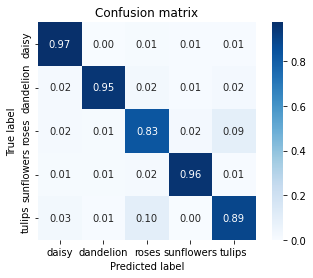

In [15]:
def show_confusion_matrix(test_labels, predictions):
    """Compute confusion matrix and normalize."""
    test_labels = test_labels[:len(predictions)] # last batch has not been considerednfor evaluation by mistake
    confusion = sk_metrics.confusion_matrix(
    test_labels, predictions)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    axis_labels = list(CLASSES.values())
    ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

show_confusion_matrix(VALIDATION_EXAMPLES_dict['label'], test_prediction)

### Model Serialization (Production)

In [30]:
# Load serialized model

loaded = tf.saved_model.load("{}/saved_model/".format(model_checkpoint_dir))
model = loaded.signatures['serving_default']

# Lets evaluate accuracy and see whether it matches the callback

accuracy_metric = tf.keras.metrics.Accuracy('accuracy')
for (batch_inputs, batch_labels) in tqdm.tqdm(validation_dataset):
  model_outputs = model(**batch_inputs)
  predicted_ids = tf.argmax(model_outputs['class_logits'], axis=1)
  label_ids = batch_labels['labels']
  accuracy_metric.update_state(label_ids, predicted_ids) 
print("Validation Accuracy", accuracy_metric.result().numpy())

100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

Validation Accuracy 0.921875


### Advanced Serialization (Include pre-processing with models)

In [34]:
# Advanced serialzation
from tf_transformers.core import ClassificationChainer
model = model_fn()
model.load_checkpoint(model_checkpoint_dir)

# Serialize feature extractor and model together
model = ClassificationChainer(feature_extractor.get_model(), model)
model = model.get_model() # get_model will return tf.keras.Model , nothing fancy

model.save_serialized('{}/saved_model_vit_model/'.format(model_checkpoint_dir)) # Do not use `model_transformers_serialzed` here

INFO:tensorflow:Assets written to: MODELS/vit_flower_classification/saved_model_vit_model/assets


INFO:tensorflow:Assets written to: MODELS/vit_flower_classification/saved_model_vit_model/assets


### Evaluate Accuracy using joint Serializaton Model

In [37]:
# Load jointly serialized model

loaded = tf.saved_model.load("{}/saved_model_vit_model/".format(model_checkpoint_dir))
model = loaded.signatures['serving_default']

# Now lets evaluate accuracy again
# This time, we have to provide only raw image path, model will be pre-processing it internally

# Create a validation dataset
validation_image_dataset = tf.data.Dataset.from_tensor_slices(({'image': VALIDATION_EXAMPLES_dict['image_path'] }, 
                                                             {'labels': VALIDATION_EXAMPLES_dict['label']})
                                                             ).batch(batch_size)

# Evaluate accuracy
accuracy_metric = tf.keras.metrics.Accuracy('accuracy')
for (batch_inputs, batch_labels) in tqdm.tqdm(validation_image_dataset):
    model_outputs = model(**batch_inputs)
    predicted_ids = tf.argmax(model_outputs['class_logits'], axis=1)
    label_ids = batch_labels['labels']
    accuracy_metric.update_state(label_ids, predicted_ids) 
print("Validation Accuracy", accuracy_metric.result().numpy())

100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

Validation Accuracy 0.92391306


### Plot Mistakes of Model

In [40]:
# :len(test_prediction) is used because we accidently not used last batch for test predictions
                                                                    
test_labels = VALIDATION_EXAMPLES_dict['label'][:len(test_prediction)] 
incorrect_example_indexes = []
for i in range(len(test_labels)):
    if test_labels[i] != test_prediction[i]:
        incorrect_example_indexes.append(i)
        
incorrect = [(TEST_EXAMPLES[index], CLASSES[test_prediction[index]]) for index in incorrect_example_indexes]
# Plot 20 mistakes
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])